In [1]:
import pandas as pd
import numpy as np
from sklearn import decomposition
import matplotlib.pyplot as plt
import os
import skfuzzy as fuzz



# Clustering Embedings

In [2]:
embeddings_matrix = pd.read_csv('../data/02_interim/image_embeddings_matrix.csv', header=None)
embeddings_matrix.shape

(474, 1024)

In [3]:
image_results_df = pd.read_csv( "../data/02_interim/image_results.csv")
image_results_df = image_results_df[["lat","lon"]]
image_results_df.shape

(474, 2)

In [4]:
embeddings_matrix

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.172947,-0.087920,0.311514,-0.378930,0.371648,-0.146677,0.936442,0.007682,-0.074870,0.017992,...,-0.064590,0.126180,-0.082757,-0.059197,-0.073073,0.065889,-0.012861,0.066144,0.004592,0.109164
1,0.282191,-0.131781,0.555519,-0.425269,0.233957,0.056380,0.702789,-0.002001,-0.043222,0.041632,...,-0.018109,0.028234,0.038871,-0.013033,-0.040409,0.026142,-0.039914,0.091459,-0.018597,0.019887
2,0.259768,-0.149201,0.479077,-0.331304,0.130961,0.019831,0.611122,-0.019437,-0.069374,0.019576,...,-0.043207,0.086030,0.034934,-0.023349,0.063771,0.106099,-0.018082,0.033380,0.020758,0.081140
3,0.260868,-0.072569,0.476380,-0.351324,0.135284,-0.076456,0.636436,0.046691,-0.081169,0.047602,...,-0.064513,0.096189,0.016186,-0.008662,-0.068636,0.042732,-0.067640,0.070107,0.028358,-0.048838
4,0.228060,-0.068779,0.526474,-0.486239,0.198133,-0.008870,0.654265,0.047370,-0.058840,0.026129,...,-0.017925,0.132057,0.031708,0.010147,-0.009883,0.088773,0.014616,0.058730,0.038700,0.017737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0.276002,0.017523,0.513263,-0.584871,0.214773,-0.054412,0.834677,-0.026777,-0.109575,0.032781,...,-0.039839,0.043613,-0.037428,-0.007739,0.003866,0.065101,0.021289,0.074430,0.012817,-0.049983
470,0.276235,-0.010428,0.524440,-0.502039,0.306812,-0.018056,0.893754,0.008473,-0.075007,0.038385,...,-0.042223,0.040645,-0.017791,-0.031795,-0.068450,0.046683,-0.013214,0.083126,0.024257,-0.053885
471,0.277944,-0.109035,0.545450,-0.505904,0.196599,0.015682,0.675462,0.025374,-0.049824,0.057092,...,-0.023463,0.032933,0.072058,-0.005188,-0.020755,0.071788,0.029356,0.088116,0.021603,-0.025861
472,0.257208,-0.082179,0.483540,-0.419950,0.187455,-0.011332,0.723483,0.039092,-0.060796,0.009061,...,-0.029156,0.060833,0.007981,-0.005619,-0.033785,0.063957,0.027781,0.050141,0.037685,-0.085850


## PCA

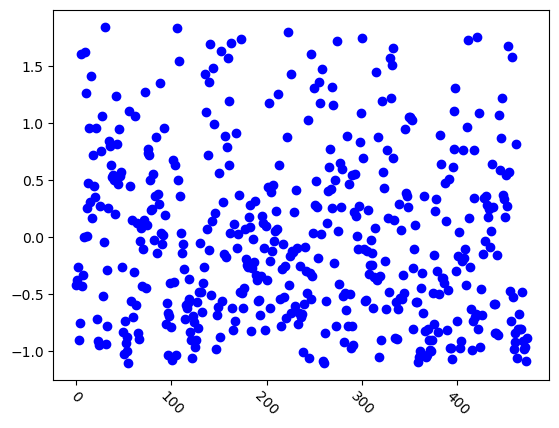

In [5]:
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings_matrix)

plt.xticks(rotation=-45)

indices = np.arange(len(pca_result))

plt.scatter(indices, pca_result, color="blue")

In [6]:
pca_flat = pca_result.flatten()
pca_df = image_results_df[["lat", "lon"]].copy()
pca_df["pca_result"] = pca_flat


pca_df

,lat,lon,pca_result
0,24.45118,54.39696,-0.417218
1,34.52813,69.17233,-0.373100
2,41.32750,19.81889,-0.258130
3,40.18111,44.51361,-0.899530
4,-8.83682,13.23432,-0.746722
...,...,...,...
469,-29.12107,26.21400,-0.904789
470,-33.92584,18.42322,-0.975073
471,-15.40669,28.28713,-0.961974
472,-17.82772,31.05337,-1.082307


In [7]:
! pip install scikit-fuzzy

## Fuzzy C means

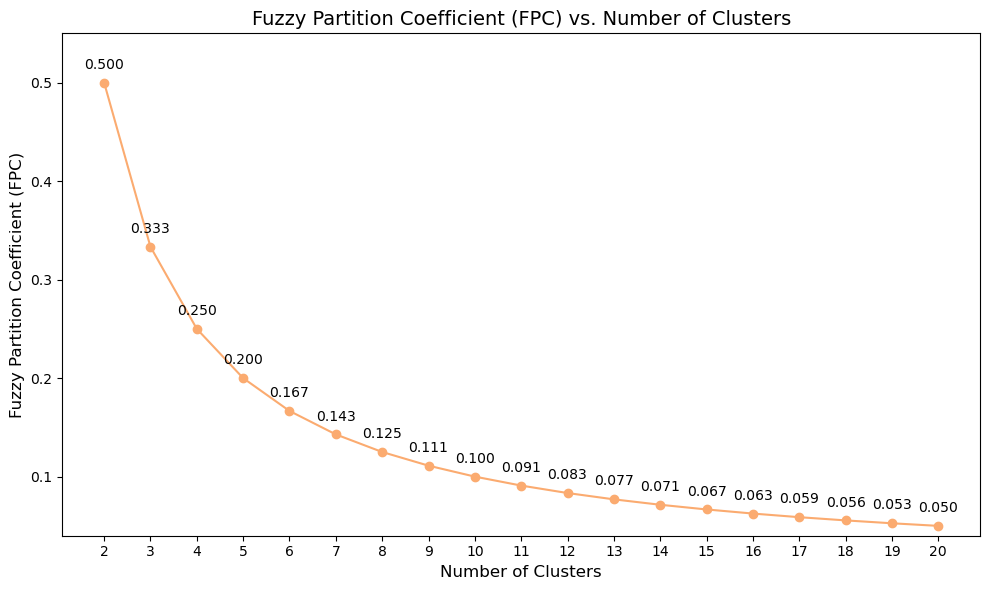

In [8]:
# Range of clusters from 2 to 20 for plotting
all_n_clusters = range(2, 21)  # For plotting
save_n_clusters = [5, 10, 20]  # For saving

# FCM parameters
m = 2.0  # Fuzziness parameter
error = 0.005  # Error tolerance
maxiter = 1000  # Maximum iterations

# DataFrame to store results for the selected clusters
all_membership_df = pd.DataFrame()

# List to store Partition Coefficient values
partition_coef_values = []

# Iterate over all n_clusters values for plotting
for n_clusters in all_n_clusters:
    
    # Apply fuzzy C-means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        embeddings_matrix.T,
        c=n_clusters,
        m=m,
        error=error,
        maxiter=maxiter,
        init=None,
        seed=42,
    )
    
    # Store the Partition Coefficient value
    partition_coef_values.append(fpc)
    
    # Save results for specific clusters
    if n_clusters in save_n_clusters:
        membership_df = pd.DataFrame(u.T, columns=[f"Cluster_{n_clusters}_{i}" for i in range(n_clusters)])
        all_membership_df = pd.concat([all_membership_df, membership_df], axis=1)


# Plot the Partition Coefficient
plt.figure(figsize=(10, 6))
plt.plot(all_n_clusters, partition_coef_values, 'o-', color='#fbab70')  # Line and points in specified color
plt.title('Fuzzy Partition Coefficient (FPC) vs. Number of Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Fuzzy Partition Coefficient (FPC)', fontsize=12)
plt.xticks(all_n_clusters)

# Set the y-axis limit to make space for the labels
plt.ylim(bottom=min(partition_coef_values) - 0.01, top=max(partition_coef_values) + 0.05)

# Add labels to the points
for i, txt in enumerate(all_n_clusters):
    plt.annotate(f"{partition_coef_values[i]:.3f}", 
                 (all_n_clusters[i], partition_coef_values[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

save_path = '../figures/'
file_path = os.path.join(save_path, f'05_fuzzy_partition_coefficient.png')
plt.tight_layout()
plt.savefig(file_path)


plt.show()


In [9]:
# Crear datos artificiales con 3 grupos
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=300, centers=3, n_features=5, random_state=42)
X = X.T  # (features, samples)

# Correr fuzzy C-means
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X,
    c=3,
    m=2,
    error=0.005,
    maxiter=1000,
    init=None,
    seed=42,
)

print("FPC:", fpc)


FPC: 0.9255136552165621


In [10]:
partition_coef_values

[0.5000002067900786,
 0.33333367700663913,
 0.2500002398830593,
 0.2000002369374673,
 0.16666692876471192,
 0.14285734665196984,
 0.1250001960577905,
 0.11111138194560047,
 0.10000025580527869,
 0.09090942509513472,
 0.08333367778890316,
 0.07692341208073998,
 0.07142887101305317,
 0.06666691718401829,
 0.06250025455402672,
 0.05882377979103824,
 0.05555575058762231,
 0.05263189767980222,
 0.050000325829692376]

In [11]:
# Complete the final DataFrame
all_membership_df = pd.concat([image_results_df, all_membership_df], axis=1)
all_membership_df = all_membership_df.merge(pca_df, how='left', on=['lat', 'lon'])

all_membership_df

,lat,lon,Cluster_5_0,Cluster_5_1,Cluster_5_2,Cluster_5_3,Cluster_5_4,Cluster_10_0,Cluster_10_1,Cluster_10_2,...,Cluster_20_11,Cluster_20_12,Cluster_20_13,Cluster_20_14,Cluster_20_15,Cluster_20_16,Cluster_20_17,Cluster_20_18,Cluster_20_19,pca_result
0,24.45118,54.39696,0.199943,0.199860,0.200040,0.200124,0.200033,0.100021,0.099852,0.100068,...,0.050045,0.050037,0.049996,0.050059,0.049936,0.050036,0.050129,0.049987,0.050072,-0.417218
1,34.52813,69.17233,0.199927,0.199813,0.200057,0.200161,0.200042,0.100036,0.099798,0.100097,...,0.050061,0.050047,0.049996,0.050078,0.049910,0.050046,0.050170,0.049979,0.050096,-0.373100
2,41.32750,19.81889,0.199916,0.199790,0.200063,0.200183,0.200048,0.100036,0.099775,0.100108,...,0.050065,0.050057,0.049993,0.050093,0.049902,0.050044,0.050187,0.049984,0.050108,-0.258130
3,40.18111,44.51361,0.199725,0.199326,0.200198,0.200596,0.200156,0.100107,0.099288,0.100336,...,0.050213,0.050179,0.049976,0.050292,0.049689,0.050157,0.050623,0.049940,0.050351,-0.899530
4,-8.83682,13.23432,0.199776,0.199447,0.200164,0.200487,0.200127,0.100092,0.099412,0.100280,...,0.050174,0.050148,0.049981,0.050241,0.049743,0.050124,0.050507,0.049952,0.050287,-0.746722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,-29.12107,26.21400,0.199795,0.199497,0.200146,0.200445,0.200117,0.100078,0.099470,0.100247,...,0.050160,0.050132,0.049982,0.050216,0.049769,0.050122,0.050466,0.049953,0.050261,-0.904789
470,-33.92584,18.42322,0.199742,0.199370,0.200183,0.200559,0.200147,0.100097,0.099338,0.100308,...,0.050201,0.050166,0.049978,0.050270,0.049712,0.050155,0.050586,0.049941,0.050328,-0.975073
471,-15.40669,28.28713,0.199703,0.199270,0.200215,0.200644,0.200168,0.100118,0.099228,0.100366,...,0.050231,0.050194,0.049974,0.050317,0.049662,0.050168,0.050675,0.049934,0.050380,-0.961974
472,-17.82772,31.05337,0.199712,0.199298,0.200205,0.200623,0.200163,0.100109,0.099260,0.100348,...,0.050222,0.050188,0.049973,0.050306,0.049678,0.050163,0.050651,0.049939,0.050366,-1.082307


In [12]:
all_membership_df.columns

Index(['lat', 'lon', 'Cluster_5_0', 'Cluster_5_1', 'Cluster_5_2',
       'Cluster_5_3', 'Cluster_5_4', 'Cluster_10_0', 'Cluster_10_1',
       'Cluster_10_2', 'Cluster_10_3', 'Cluster_10_4', 'Cluster_10_5',
       'Cluster_10_6', 'Cluster_10_7', 'Cluster_10_8', 'Cluster_10_9',
       'Cluster_20_0', 'Cluster_20_1', 'Cluster_20_2', 'Cluster_20_3',
       'Cluster_20_4', 'Cluster_20_5', 'Cluster_20_6', 'Cluster_20_7',
       'Cluster_20_8', 'Cluster_20_9', 'Cluster_20_10', 'Cluster_20_11',
       'Cluster_20_12', 'Cluster_20_13', 'Cluster_20_14', 'Cluster_20_15',
       'Cluster_20_16', 'Cluster_20_17', 'Cluster_20_18', 'Cluster_20_19',
       'pca_result'],
      dtype='object')

In [13]:
all_membership_df.to_csv("../data/02_interim/image_results_v2.csv", index=False)